In [1]:
!nvidia-smi

Sun Apr 11 05:28:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Обновление tensorflow
!pip install tensorflow --upgrade
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-i6hv_h82
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-i6hv_h82
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=8a6cc85689033a3984f223cab52f5136b4e0fee5b97617652fd864478734c915
  Stored in directory: /tmp/pip-ephem-wheel-cache-lnm_vxlk/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
import zipfile
import csv
import sys
import os
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

#from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification', 'sfcarclassif']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
# сохраняем версии пакетов
!pip freeze > requirements.txt

# Setup

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

RANDOM_SEED          = 42

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sfcarclassif/'
PATH = "../working/" # рабочая директория

# EDA

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


Нет пропусков.

In [8]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Данные распределены равномерно

In [9]:
train_df['Category'].nunique()

10

В датасете представлено 10 марок машин

In [10]:
# Исходные данные можно распаковать в output, используя ниже приведенный код

#print('Распаковываем картинки')

#for data_zip in ['train.zip', 'test.zip']:
#    with zipfile.ZipFile('../'+data_zip,"r") as z:
#        z.extractall(PATH)
        
#print(os.listdir(PATH))

# Однако при такой распаковке возникает проблема сохранения файла submission
# Поэтому распакованные исходные данные добавили из базы каггла

Пример картинок


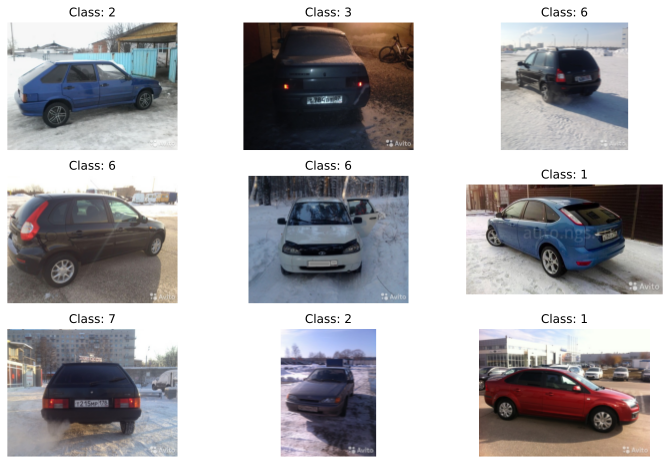

In [11]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+f'train/train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки представлены разного размера

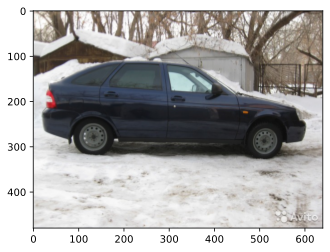

(640, 480)

In [12]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(DATA_PATH+f'train/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [13]:
#delete df no longer needed
del train_df
#collect residual garbage
gc.collect()

20045

# Аугментация данных

In [14]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [15]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

# Генерация данных

In [16]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


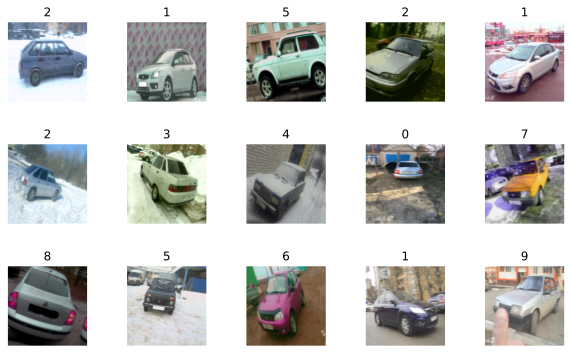

In [17]:
train_datagen.show_data(rows=3, cols=5)

# Модель

Download pre-trained model

In [18]:
# Загрузка модели efficientnet
!pip install -q efficientnet

In [19]:
#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications.inception_v3 import InceptionV3
import efficientnet.keras as efn 

In [20]:
# Pre-trained model

#base_model = Xception(weights='imagenet', 
#                      include_top=False, 
#                      input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                         include_top=False, 
#                         input_shape = input_shape)

base_model = efn.EfficientNetB5(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

115515392/115515256 [==============================] - 2s 0us/step


In [21]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [22]:
# freeze the pre-trained model weights, train only the top layers
base_model.trainable = False

In [23]:
model=Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 527,626
Non-trainable params: 28,514,032
______________________________________

In [25]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f1e15972290> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1df8a32790> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1de057d610> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1de0578810> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1de0580a50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1de0580a10> True


# Fit

In [26]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [27]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [28]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 368s 210ms/step - loss: 1.8631 - accuracy: 0.3822 - val_loss: 1.0619 - val_accuracy: 0.6289

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 227s 137ms/step - loss: 1.4095 - accuracy: 0.5050 - val_loss: 1.0545 - val_accuracy: 0.6345

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 237s 143ms/step - loss: 1.3035 - accuracy: 0.5420 - val_loss: 0.9338 - val_accuracy: 0.6808

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 233s 141ms/step - loss: 1.2771 - accuracy: 0.5499 - val_loss: 0.9202 - val_accuracy: 0.6787

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 235s 142ms/step - loss: 1.2161 - accuracy: 0.5705 - val_loss: 0.8943 - val_accuracy: 0.7015

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
1654/1654 [==============

In [29]:
#model.save('../working/model_last.hdf5') 
model.load_weights('best_model.hdf5')

In [30]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 33s 113ms/step - loss: 0.8581 - accuracy: 0.7037
Accuracy: 70.37%


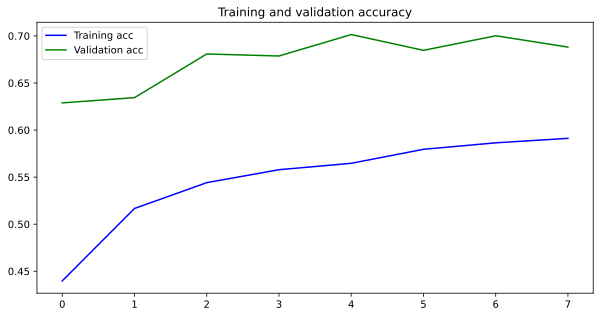

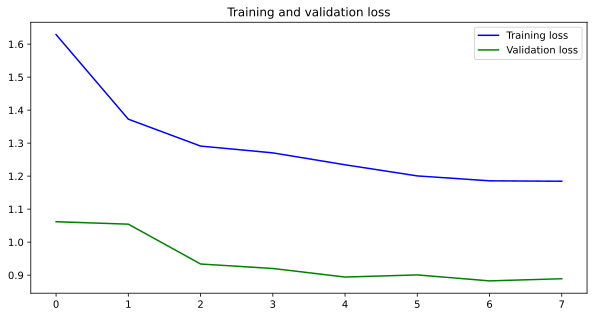

In [31]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Step 2
### defrost a half of the pre-trained model weights

In [32]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [33]:
LR=0.0001
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 26,777,098
Non-trainable params: 2,264,560
____________________________________

In [35]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 310s 175ms/step - loss: 1.4119 - accuracy: 0.5404 - val_loss: 0.4252 - val_accuracy: 0.8522

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 305s 184ms/step - loss: 0.6397 - accuracy: 0.7815 - val_loss: 0.2985 - val_accuracy: 0.8978

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 286s 173ms/step - loss: 0.4551 - accuracy: 0.8425 - val_loss: 0.2777 - val_accuracy: 0.9038

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 283s 171ms/step - loss: 0.3711 - accuracy: 0.8725 - val_loss: 0.2478 - val_accuracy: 0.9171

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 280s 169ms/step - loss: 0.3070 - accuracy: 0.9019 - val_loss: 0.2314 - val_accuracy: 0.9201

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
1654/1654 [==============

In [36]:
#model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5') 

In [37]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 33s 114ms/step - loss: 0.2272 - accuracy: 0.9270
Accuracy: 92.70%


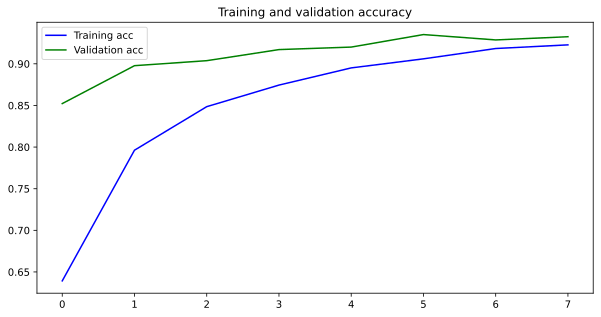

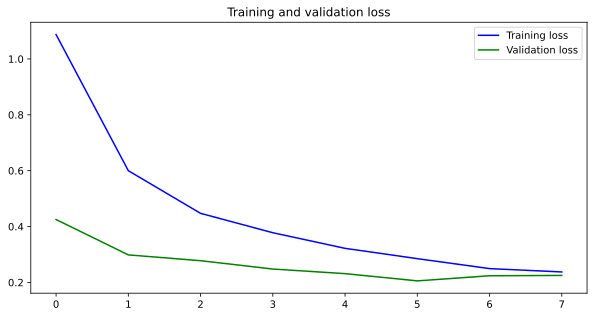

In [38]:
plot_history(history)

## Step 3
### defrost three quarters of the pre-trained model weights

In [39]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [40]:
LR=0.00001

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,603,274
Non-trainable params: 438,384
______________________________________

In [42]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 330s 185ms/step - loss: 0.2069 - accuracy: 0.9289 - val_loss: 0.1880 - val_accuracy: 0.9403

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 309s 187ms/step - loss: 0.1742 - accuracy: 0.9426 - val_loss: 0.1962 - val_accuracy: 0.9377

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 306s 185ms/step - loss: 0.1626 - accuracy: 0.9470 - val_loss: 0.1871 - val_accuracy: 0.9394

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 289s 175ms/step - loss: 0.1546 - accuracy: 0.9470 - val_loss: 0.1857 - val_accuracy: 0.9424

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 285s 173ms/step - loss: 0.1428 - accuracy: 0.9540 - val_loss: 0.1927 - val_accuracy: 0.9403

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
1654/1654 [==============

In [43]:
#model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [44]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 33s 114ms/step - loss: 0.1723 - accuracy: 0.9480
Accuracy: 94.80%


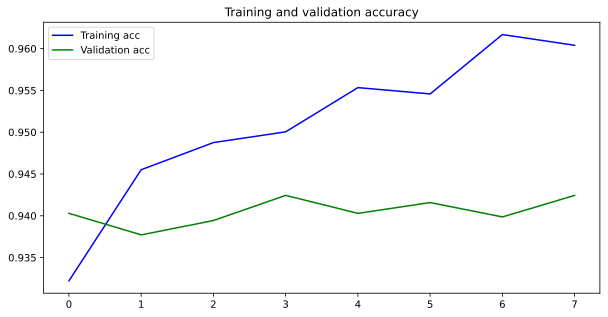

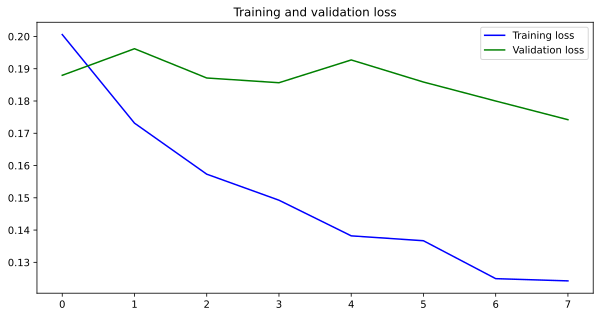

In [45]:
plot_history(history)

## Step 4
### complete weights defrosting

In [46]:
base_model.trainable = True
LR=0.000001
#EPOCHS = 10

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [47]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 447s 256ms/step - loss: 0.1360 - accuracy: 0.9570 - val_loss: 0.1762 - val_accuracy: 0.9454

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 433s 262ms/step - loss: 0.1369 - accuracy: 0.9568 - val_loss: 0.1607 - val_accuracy: 0.9502

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 422s 255ms/step - loss: 0.1338 - accuracy: 0.9553 - val_loss: 0.1638 - val_accuracy: 0.9519

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 432s 261ms/step - loss: 0.1142 - accuracy: 0.9660 - val_loss: 0.1704 - val_accuracy: 0.9463

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
Epoch 5/8
1654/1654 [==============================] - 423s 256ms/step - loss: 0.1204 - accuracy: 0.9608 - val_loss: 0.1550 - val_accuracy: 0.9545


In [48]:
#model.save('../working/model_step4.hdf5') 
model.load_weights('best_model.hdf5') 

In [49]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 33s 113ms/step - loss: 0.1656 - accuracy: 0.9506
Accuracy: 95.06%


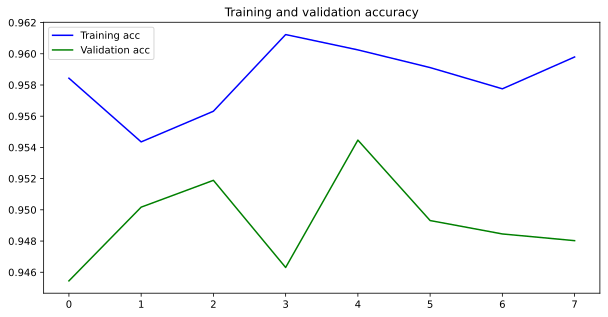

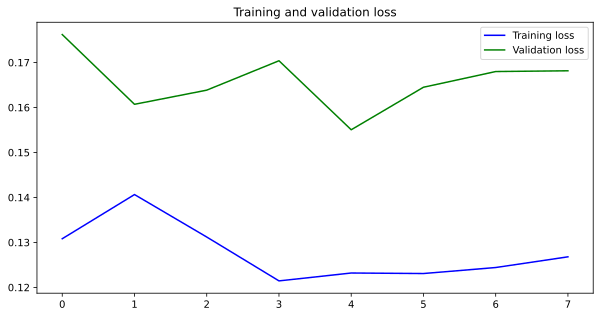

In [50]:
plot_history(history)

# Prediction after fine-tuning

In [51]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [52]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 124s 145ms/step


In [53]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

## Step 5. IMG_SIZE rise

In [54]:
EPOCHS               = 6
BATCH_SIZE           = 2 
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [55]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])

In [56]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [57]:
# Re-create the network with the new size of the input data

#base_model = Xception(weights='imagenet', 
#                            include_top=False, 
#                            input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                            include_top=False, 
#                            input_shape = input_shape)


base_model = efn.EfficientNetB5(weights='imagenet', 
                            include_top=False, 
                            input_shape = input_shape)

In [58]:
base_model.trainable = True

In [59]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])
model.load_weights('best_model.hdf5')

In [60]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/6
6616/6616 [==============================] - 2269s 339ms/step - loss: 1.1755 - accuracy: 0.7058 - val_loss: 0.1454 - val_accuracy: 0.9639

Epoch 00001: saving model to best_model.hdf5
Epoch 2/6
6616/6616 [==============================] - 2246s 339ms/step - loss: 0.7009 - accuracy: 0.8327 - val_loss: 0.1406 - val_accuracy: 0.9695

Epoch 00002: saving model to best_model.hdf5
Epoch 3/6
6616/6616 [==============================] - 2241s 339ms/step - loss: 0.6242 - accuracy: 0.8600 - val_loss: 0.1428 - val_accuracy: 0.9695

Epoch 00003: saving model to best_model.hdf5
Epoch 4/6
6616/6616 [==============================] - 2235s 338ms/step - loss: 0.5849 - accuracy: 0.8752 - val_loss: 0.1375 - val_accuracy: 0.9691

Epoch 00004: saving model to best_model.hdf5
Epoch 5/6
6616/6616 [==============================] - 2242s 339ms/step - loss: 0.5945 - accuracy: 0.8657 - val_loss: 0.1584 - val_accuracy: 0.9716

Epoch 00005: saving model to best_model.hdf5
Epoch 6/6
6616/6616 [=========

In [61]:
#!find /kaggle/working -name "*.hdf5" -type f -delete

In [62]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 69s 59ms/step - loss: 0.1730 - accuracy: 0.9717
Accuracy: 97.17%


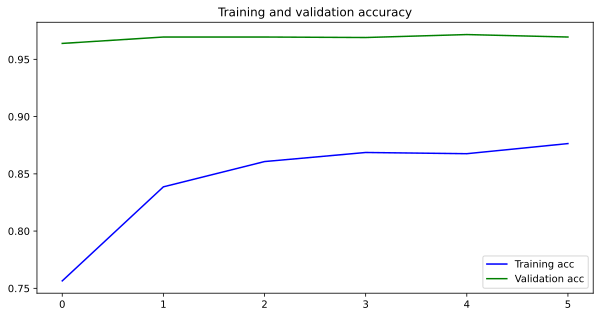

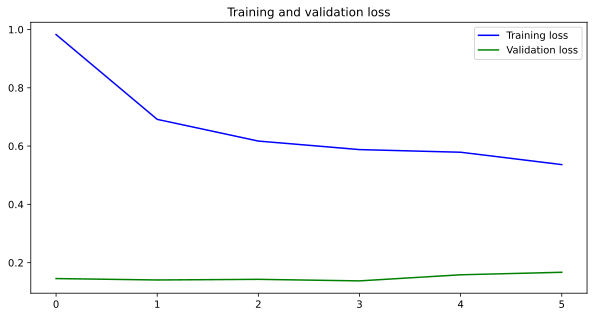

In [63]:
plot_history(history)

# Prediction after IMG_SIZE rise

In [64]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

3338/3338 [==============================] - 186s 55ms/step


In [65]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

In [66]:
submission.to_csv('submission_IMG_SIZE.csv', index=False)

# Test Time Augmentation (TTA)

Augment test images.         
Make several predictions of one picture in a different way.         
=> The final prediction is obtained by taking the average of several predictions.

In [67]:
model.load_weights('best_model.hdf5')

In [68]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [69]:
test_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                      directory=DATA_PATH+'test/test_upload',
                                      x_col="Id",
                                      y_col=None,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode=None,
                                      shuffle=False)

Found 6675 validated image filenames.


In [70]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

3338/3338 [==============================] - 309s 93ms/step


In [71]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [72]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 70s 60ms/step - loss: 0.1564 - accuracy: 0.9712
Accuracy: 97.12%


In [73]:
submission.to_csv('submission_TTA.csv', index=False)

In [74]:
#Удалить папку с распакованными картинками
#import shutil
#shutil.rmtree(PATH)

# Model efficiency summary          
         
Fine-tuning **Xception**         
0% weights defrosting accuracy 59.25%      
50% weights defrosting accuracy 91.88%        
75% weights defrosting accuracy 93.99%        
100% weights defrosting accuracy 93.99%       
image size rising accuracy 96.82%         
TTA accuracy **96.52%**       
          
Fine-tuning **InceptionV3**       
0% weights defrosting accuracy 61.31%      
50% weights defrosting accuracy 90.55%        
75% weights defrosting accuracy 93.86%        
100% weights defrosting accuracy 93.69%       
image size rising accuracy 94.68%         
TTA accuracy **%**          

Fine-tuning **EfficientNetB5**       
0% weights defrosting accuracy 73,55%      
50% weights defrosting accuracy 93.69%        
75% weights defrosting accuracy 94.72%        
100% weights defrosting accuracy 95.02%       
image size rising accuracy 97.25%         
TTA accuracy **%**     
          


# Итоги             
                    
В проекте применены:     
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras        
- настройка LR    
- настройка параметров регуляризации полносвязного слоя нейронной сети
- применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations
- подобраны переменные (размер картинки, батч, количество эпох)
- добавлена Batch Normalization в архитектуре “головы” модели
- SOTA архитектура сетей - Xception, InceptionV3, EfficientNetB5
- добавлена TTA (Test Time Augmentation)
                  
Ввиду ограничений на пользование ресурсами GPU и времязатратности самого просчета модели, не удалось протестировать следующие техники настройки модели:
- настройка optimizer
- настройка loss
- использование внешних датасетов для дообучения модели
               